### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data summary

We downloaded our dataset from https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification.
This is an extension to the GTZAN dataset, which is the most famous dataset for audio-related ML tasks. It is to music what MNIST is to OCR. It was originally created by George Tzanetakis in 2002 and can be found at http://marsyas.info/downloads/datasets.html, although it seems the link is dead at the time of creating this notebook.

The original GTZAN dataset is comprised under the `genres_original` directory. It contains 30-sec long audio files distributed among 10 different music genres, being

- Blues
- Classical
- Country
- Disco
- Hip-Hop
- Jazz
- Metal
- Reggae
- Rock
  
each associated with 100 audio files. The audio files are encoded into the `.wav` format which is a common format for uncompressed, raw, audio.

The extension of the dataset related to the aforementioned Kaggle page involves the addition of 2 csv files,

- `features_3_sec.csv`
- `features_30_sec.csv`

containing hand-crafted features (or summary statistics) for each audio files. *For explanations on what these statistics are and what they represent, refer to the corresponding section of the notebook.* The first CSV associates each 30-sec long audio to its statistics while in the second file, the statistics are computed on 10, 3-sec long, extracts from each audio file, thus increasing the number of samples by a factor of 10. However, it could be argued that a 3-sec extract of a song might sometimes be too short to properly identify the genre it belongs to.

Additionally, the authors of the Kaggle dataset added a directory, `images_original` containing the spectrogram visualizations for each original audio file. *Refer to this notebook's section about spectrograms for details.*

In [3]:
from sklearn.preprocessing import LabelEncoder

sec3_data = pd.read_csv("../res/features_3_sec.csv")
sec3_labels = sec3_data["label"].to_numpy()
encoded_sec3_labels = c=LabelEncoder().fit_transform(sec3_labels)

full_data = pd.read_csv("../res/features_30_sec.csv")
full_labels = full_data["label"].to_numpy()
encoded_full_labels = c=LabelEncoder().fit_transform(full_labels)

sec3_np = sec3_data.iloc[:, 2:-1].to_numpy()
full_np = full_data.iloc[:, 2:-1].to_numpy()

### Data split
There is no built-in split for the data amongst training, test, and validation set, which means we will have to address the split ourselves both for doing cross-validation on our baseline classifiers as well as when training our NN models.

## Hand-crafted features EDA

### What are the hand-crafted features and what do they represent ?

In [4]:
print(f"There are {full_data.shape[1] - 3} features.")
print([col_name for col_name in full_data.columns.to_list()[2:-1]]) # Ignore the two first: name and length, as well as last: label

There are 57 features.
['chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var', 'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean', 'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var', 'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo', 'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean', 'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var', 'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean', 'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var', 'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean', 'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var', 'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean', 'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var']


In the CSV files, each sample is associated with 57 features. *But what do they represent, broadly speaking ? If relevant, how are they computed ?*

- Andrea: ...

### Comparing univariate distributions between genres
We can visualize how different genres might or might not have different distributions in these hand-crafted features.

In [5]:
features_to_observe = ['chroma_stft_mean', 'rms_mean', 'spectral_centroid_mean', 'tempo', 'mfcc2_mean']

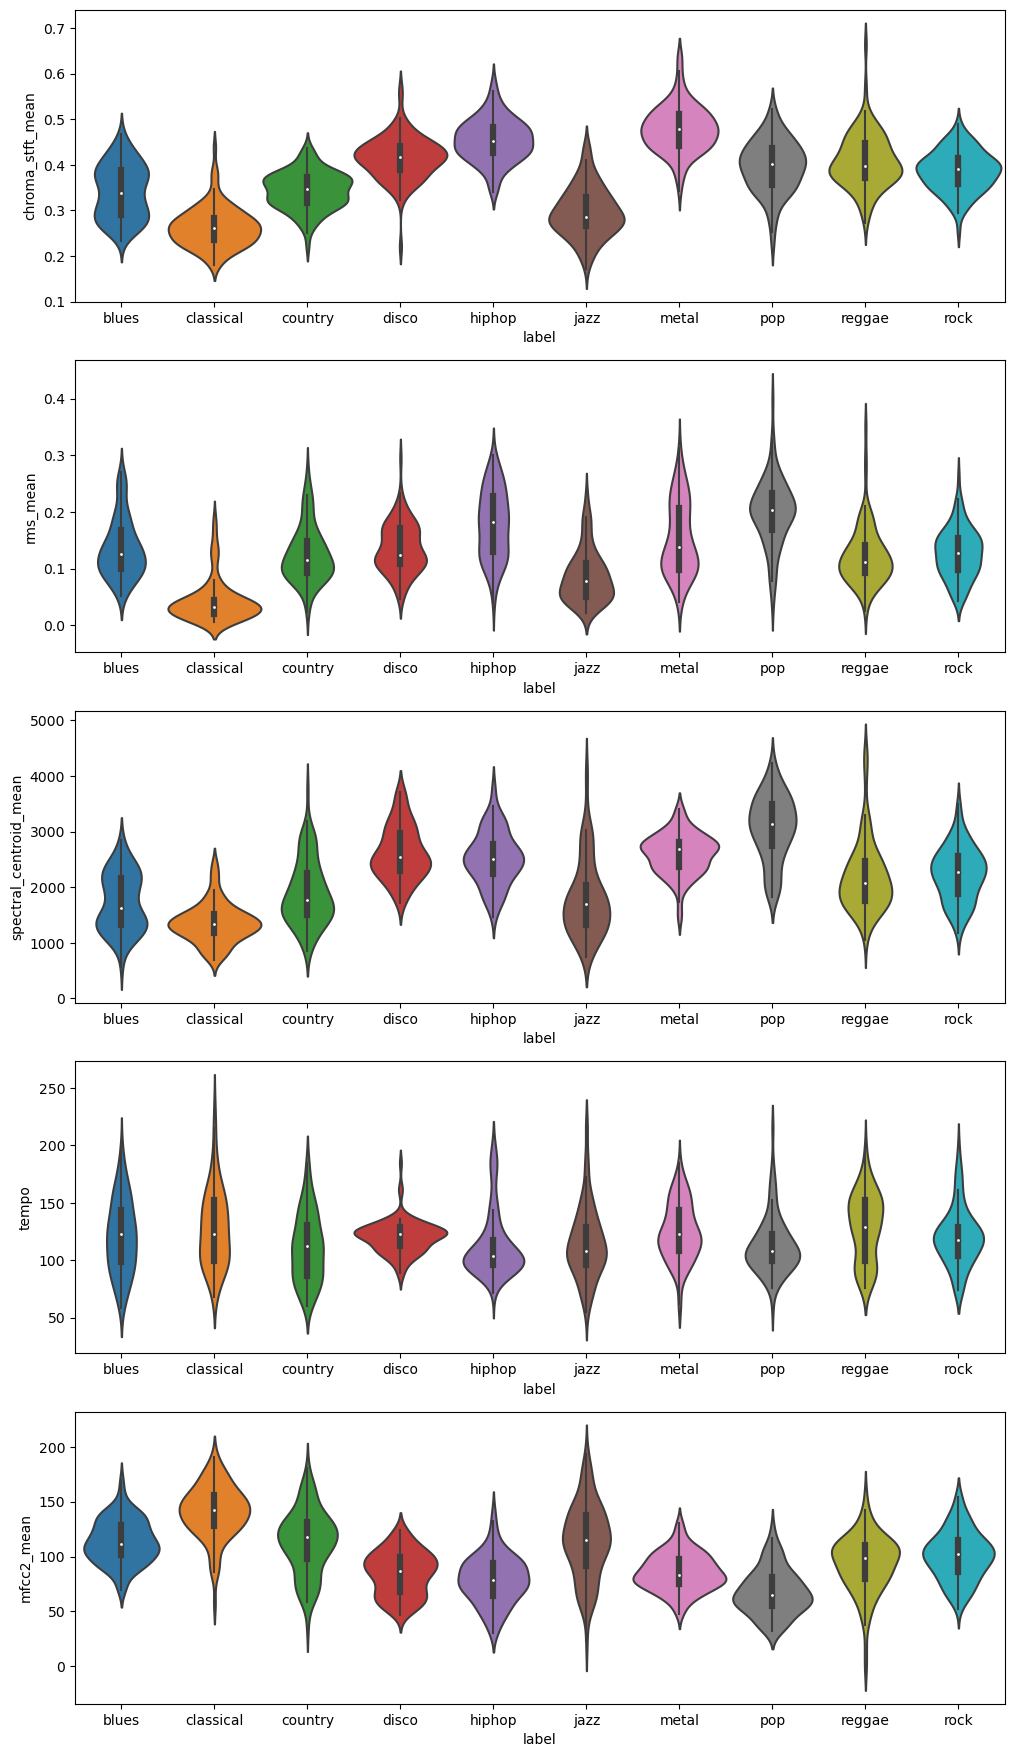

In [6]:
n_plots = len(features_to_observe)

fig, axs = plt.subplots(n_plots, 1, figsize=(12, 2 + n_plots * 4))
axs = axs.flatten()

for k, var in enumerate(features_to_observe):
    sns.violinplot(data=full_data, x="label", y=var, ax=axs[k], legend=False, width=1.0)

### Visualizing the hand-crafted feature space
In order to represent how the audio files are distributed in the feature space derived from these features, we can try performing dimensionality reduction down to perceivable 2D or 3D projections. To achieve this, we can perform PCA or manifold techniques such as t-SNE.

In [7]:
from mpl_toolkits.mplot3d import Axes3D

#### PCA

In [8]:
from sklearn.decomposition import PCA

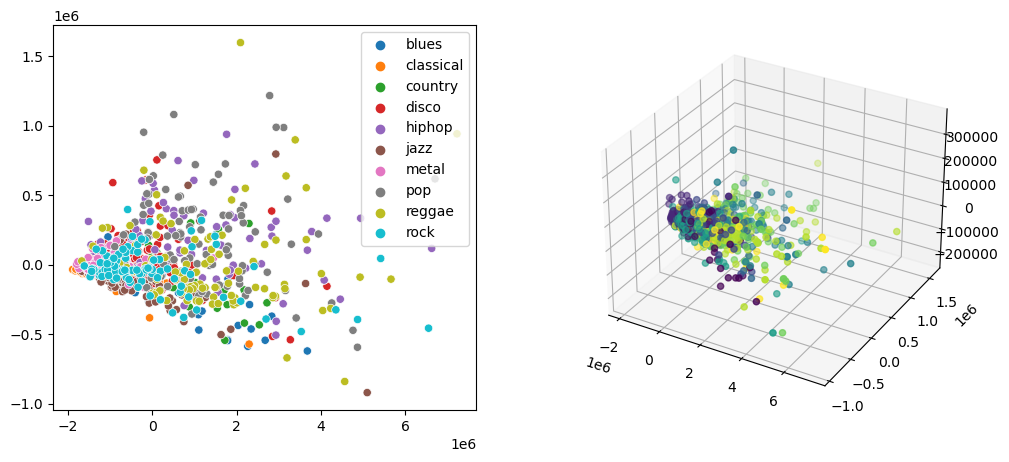

In [9]:
pca = PCA()
pca_full = pca.fit_transform(full_np)

fig = plt.figure(figsize=(12, 5))

pca_2D_ax = fig.add_subplot(121)
pca_3D_ax = fig.add_subplot(122, projection='3d')

sns.scatterplot(x=pca_full[:,0], y=pca_full[:,1], hue=full_labels, ax=pca_2D_ax)
pca_3D_ax.scatter(pca_full[:,0], pca_full[:,1], pca_full[:,2], c=encoded_full_labels)

plt.show()

In [22]:
print(
    "The first 3 principal components respectively account for",
    *[str(round(var*100, 4)) + "%," for var in pca.explained_variance_ratio_[:3]],
    f"of the total variance of the dataset, summing up to {round(np.sum(pca.explained_variance_ratio_[:3]) * 100, 4)}%.",
    "Yet it is really hard to visually separate the genres apart in the projection."
)

The first 3 principal components respectively account for 97.5836%, 2.3342%, 0.0818%, of the total variance of the dataset, summing up to 99.9996%. Yet it is really hard to visually separate the genres apart in the projection.


The fact that we obtain such high values of explained variance for the first principal components imply very high redundancy in the traditional hand-crafted feature space. Furthermore, an ideal feature space for a classification task is one where samples of a same group are close to each other while distant from other groups. In other terms, an ideal feature space minimizes the intra-class variance while maximizing the inter-class variance. The feature space derived from the hand-crafted features seemingly fails to do so.

#### t-SNE

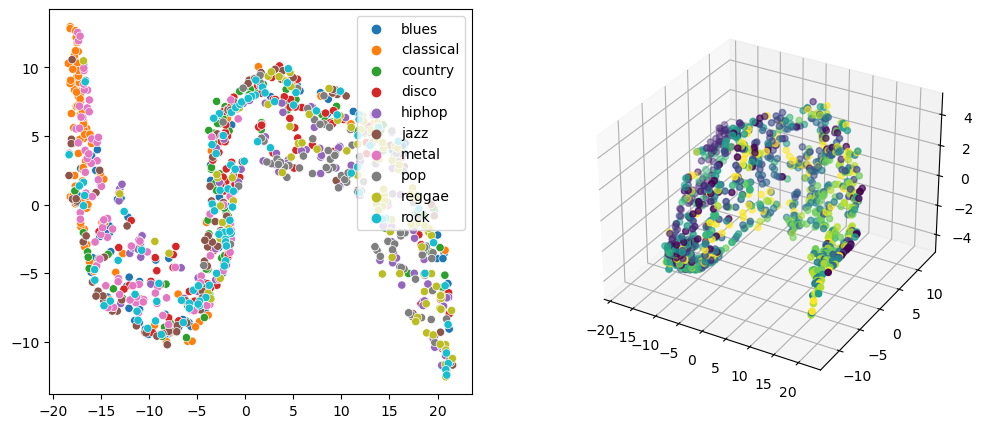

In [24]:
from sklearn.manifold import TSNE

tsne_full = TSNE(n_components=3).fit_transform(full_np)

fig = plt.figure(figsize=(12, 5))

ax_2D = fig.add_subplot(121)
ax_3D = fig.add_subplot(122, projection='3d')


sns.scatterplot(x=tsne_full[:,0], y=tsne_full[:,1], hue=full_labels, ax=ax_2D)
ax_3D.scatter(tsne_full[:,0], tsne_full[:,1], tsne_full[:,2], c=encoded_full_labels)

plt.show()

The t-SNE approach also fails to show effective natural separation between classes.

## Introducing the spectrogram visualization towards CNNs

Although the dataset we use already feature spectrogram representations of the audio files, we decided to build them ourselves for several reasons.

1. The spectrograms have been compressed into images files, zipped, uploaded on Kaggle, downloaded, unzipped... In order to be certain that we get the pixel-wise exact 2D-matrix corresponding to the audio's spectrogram, it is safer to compute it ourselves.
2. For some reason, the spectrogram images in the dataset have a white border around them, i.e would require preprocessing to get rid of, anyways.
3. The method for building the spectrograms is interesting and is relevant to study in the context of the course, as the FFT and its history was studied in the course.

### Explaining the spectrogram visualization of the audio

### How the spectrogram is derived from the audio file

https://it.mathworks.com/help/signal/ref/spectrogram.html#bultmx7_sep_mw_c056db1e-cade-47af-bf56-37cd76eee5db

### Additional EDA using the spectrogram visualization
#### What does each genre look like ?
Represent the global average spectrogram as well as the average spectrogram for each genre. Maybe it won't be relevant, maybe it will. We'll see.